# Using a Pretrained VGG16 to classify retinal damage from OCT Scans

[Transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) turns out to be useful when dealing with relatively small datasets; for examples medical images, which are harder to obtain in large numbers than other datasets. 

The model we'll use is a [VGG-16](https://www.quora.com/What-is-the-VGG-neural-network)- convolutional network, trained on [ImageNet](http://www.image-net.org/) dataset. 

This work will use [PyTorch](https://pytorch.org/) as deep learning framework and [CUDA](https://developer.nvidia.com/cuda-zone) for GPU acceleration. 

## Implementation

*Importing required Python Modules*

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  


use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

c:\Users\manch\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset loader

The dataset is divided in three categories: training, validation and test.

In [2]:
data_dir = './archive/OCT2017/OCT2017'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# Our model Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # So that our model is good at generalizing, not just memorizing
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 83484 images under train
Loaded 32 images under val
Loaded 968 images under test
Classes: 
['CNV', 'DME', 'DRUSEN', 'NORMAL']


## Helper functions

Some helper functions to visualize the dataset and the model's predictions

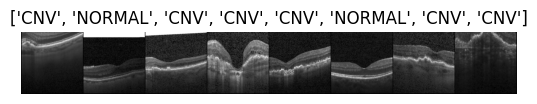

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [35]:
def visualize_model(model, num_images=6):
    was_training = model.training
    
    # Set model for evaluation
    model.train(False)
    model.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    model.train(mode=was_training) # Revert model back to original training state

This helper function will give us the accuracy of our model on the test set.

In [36]:
def eval_model(model, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0

    test_batches = len(dataloaders['test'])
    print("Evaluating model")
    print('-' * 10)

    model.eval()  # Set model to evaluate mode

    for i, data in enumerate(dataloaders['test']):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        inputs, labels = data

        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        with torch.no_grad():  # No need to track the gradients
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data).item()

        del inputs, labels, outputs, preds

    avg_loss = loss_test / dataset_sizes['test']
    avg_acc = acc_test / dataset_sizes['test']

    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)


## Creating our model and loading pre-trained weights

The [VGG-16](https://www.quora.com/What-is-the-VGG-neural-network) is able to classify 1000 different labels; we just need 4 instead. 
In order to do that we are going replace the last fully connected layer of the model with a new one with 4 output features instead of 1000. 

In PyTorch, we can access the VGG-16 classifier with `model.classifier`, which is an 6-layer array. We will replace the last entry.

We can also disable training for the convolutional layers setting `requre_grad = False`, as we will only train the fully connected classifier.

In [25]:
class RetinaModel(nn.Module):
    def __init__(self):
        super(RetinaModel, self).__init__()
        
        # Features layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4)
        )
        

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [26]:
RetinaModel = RetinaModel()

In [27]:
# Freeze training for all layers
for param in RetinaModel.features.parameters():
    param.require_grad = False

In [29]:
print(RetinaModel.classifier[6].out_features)

4


In [31]:
RetinaModel.load_state_dict(torch.load('RetinaModel.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

The output above is the summary of our model. Notice how the last layer has 4 output features as we specified. 

loss_fn : cross entropy loss

optimizer : SGD

The learning rate will start at 0.001 and a StepLR object will decrese it by a factor of 0.1 every 7 epochs

In [33]:
if use_gpu:
    RetinaModel.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(RetinaModel.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Model evaluation and visualization (before training)

In [41]:
# print("Test before training")
# eval_model(RetinaModel, criterion)

In [42]:
# visualize_model(RetinaModel) #test before training

## Training

For every epoch we iterate over all the training batches, compute the loss , and adjust the network weights with `loss.backward()` and `optimizer.step()`. 
Then we evaluate the performance over the validaton set. At the end of every epoch we print the network progress (loss and accuracy). 
The accuracy will tell us how many predictions were correct.

In [45]:
use_gpu = True

As we said before, transfer learning can work on smaller dataset too, so for every epoch we only iterate over half the trainig dataset

In [38]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders['train'])
    val_batches = len(dataloaders['val'])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        model.train()  # Set model to training mode
        
        for i, data in enumerate(dataloaders['train']):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
            # Use full training dataset
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
                
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data).item()
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        
        avg_loss = loss_train / dataset_sizes['train']
        avg_acc = acc_train / dataset_sizes['train']
        
        model.eval()  # Set model to evaluate mode
        
        with torch.no_grad():
            for i, data in enumerate(dataloaders['val']):
                if i % 100 == 0:
                    print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                    
                inputs, labels = data
                
                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
                    
                outputs = model(inputs)
                
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss_val += loss.item()
                acc_val += torch.sum(preds == labels.data).item()
                
                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes['val']
        avg_acc_val = acc_val / dataset_sizes['val']
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
        
        scheduler.step()
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model


In [44]:
use_gpu=True

In [43]:
# RetinaModel = train_model(RetinaModel, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)
# torch.save(RetinaModel.state_dict(), 'RetinaModel.pt')

## As We already loaded the trained model

## Model evaluation and visualization (after training)

In [39]:
eval_model(RetinaModel, criterion)

Evaluating model
----------
Test batch 100/121
Evaluation completed in 2m 27s
Avg loss (test): 0.0025
Avg acc (test): 0.9979
----------


C:\Users\manch\AppData\Local\Temp\ipykernel_11600\1473273267.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)


Ground truth:


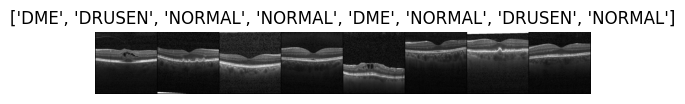

Prediction:


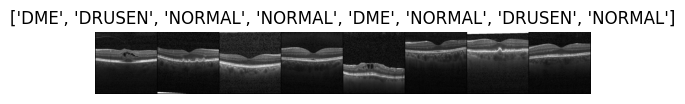

Ground truth:


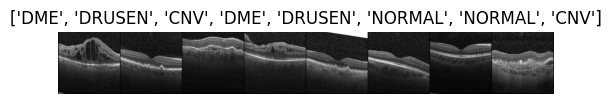

Prediction:


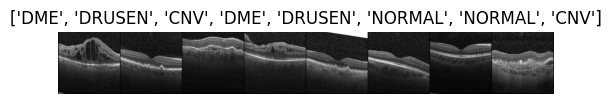

Ground truth:


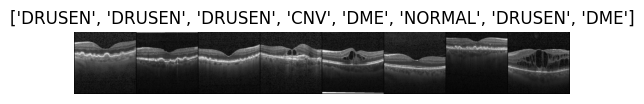

Prediction:


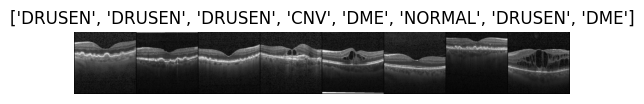

Ground truth:


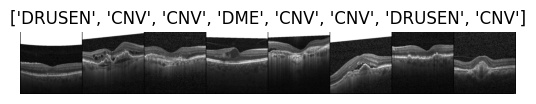

Prediction:


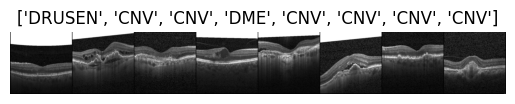

In [40]:
visualize_model(RetinaModel, num_images=32)

--------------------------------------------------------------------------THE END-------------------------------------------------------------------------------------------------